<a href="https://colab.research.google.com/github/alifele/MedicalPhysicsCodes/blob/main/radio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
N1_0 = 100.0
N2_0 = 0.0
lambda1 = 40
lambda2 = 30
dt = 0.0001
N1 = [N1_0]
N2 = [N2_0]

In [3]:
for i in range(1000):
  dN1 = -lambda1 * N1[i] * dt
  N1.append(dN1 + N1[i])
  dN2 = -lambda2 * N2[i] * dt - dN1
  N2.append(dN2 + N2[i])

  

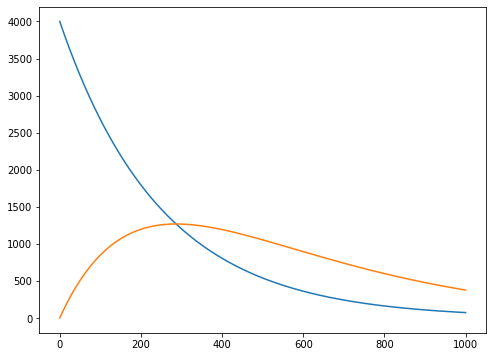

In [4]:
plt.figure(figsize=(8,6))
plt.plot(lambda1 * np.array(N1))
plt.plot(lambda2 * np.array(N2))

In [136]:
Names = ["A","B","C"]
Branch = np.array([[0,1,0],[0,0,1],[0,0,1]])
Decay = np.array([[0,30,0],[0,0,20],[0,0,0]])
eff_Decay = (Branch @ Decay.T).diagonal()

In [137]:
N = np.array([[100,0,0],[0,0,0],[0,0,0]])


In [138]:
N_List = [N.sum(axis=1)]
dt = 0.001

In [139]:
for i in range(1000):
  X = Decay.T @ N
  dN = (-Branch@X + Branch.T@X.T)*dt
  N = N + dN
  N_List.append(N_List[i] + dN.sum(axis=1))

In [140]:
N_List = np.array(N_List)

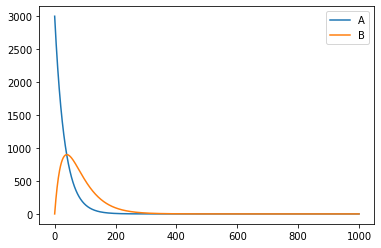

In [143]:
for i in range(2):
  plt.plot(N_List[:,i] * eff_Decay[i], label=Names[i])

plt.legend()